# **Lab 7b: Explainable Machine Learning in Geospatial Analysis: Regression**
## Introduction
Explainable machine learning (ML) methods are essential for interpreting the decision-making processes of complex or “black-box” models. These methods aim to reveal which input features most significantly influence model predictions, thereby improving transparency and trust in ML outcomes.

We will model aboveground biomass density (AGBD) using the Global Ecosystem Dynamics Investigation (GEDI) Level 4A (L4A), Sentinel-2 (S2), Normalized Difference Vegetation Index (NDVI), Canopy Chlorophyll Content Index (CCCI), Specific Leaf Area Vegetation Index (SLAVI), and a random forest model. We also employ SHAP (Shapley Additive exPlanations), and surrogate models to gain insights in the random forest model.

## Setting-up Colab
### Mount your Google Drive
First, make sure that your data is loaded in Google Drive. After that mount your Google Drive using the code below.

In [ ]:
# Import Google drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, import the required libraries

In [ ]:
# # Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
from sklearn.inspection import permutation_importance # PFI - Permutation Feature Importance
from sklearn.tree import DecisionTreeRegressor, plot_tree
import seaborn as sns
import joblib # Import joblib library

### Access datasets and define paths
Access the necessary datasets and then define the target (aboveground biomass density) and predictor variables (Sentinel-2 bands and vegetation indices). We also difine the data and model paths.

In [ ]:
# Define the target and predictor variables
LABEL = ['agbd'] # target variable
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','NDVI','CCCI','SLAVI'] # predictor variables
SAMPLE_PATH = '/content/drive/My Drive/Maf_Datasets/SampleAGBD_Filtered21.csv' # With filtered agbd
MODEL_PATH = '/content/drive/MyDrive/Maf_Datasets/best_rf_model.pkl' # Define model path

## Import training datasets and split training data
Next, we import the sample training dataset and split it into training and test datasets.

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)[FEATURES + LABEL]
samples

# Split into train and test
train, test = train_test_split(samples, test_size=0.2, shuffle=True, random_state=42)

# Get variables input and output
X_train = train[FEATURES]
X_test = test[FEATURES]
y_train = train[LABEL].astype(float)
y_test = test[LABEL].astype(float)

# Show the data shape
print(f'Train features: {X_train.shape}\nTest features: {X_test.shape}\nTrain label: {y_train.shape}\nTest label: {y_test.shape}')

Train features: (3626, 12)
Test features: (907, 12)
Train label: (3626, 1)
Test label: (907, 1)


## Perform Explainable Machine Learning (xML)
### Introduction
We will use Explainable Machine Learning (xML) methods such as  SHAP (Shapley Additive exPlanations) and surrogate models to gain insights in the random forest model. These approaches provide valuable insights into the inner workings of various machine learning models, making them versatile tools for comprehending these models.

Let's start by loading and extracting the saved random forest model from the dictionary.

In [ ]:
# Load the dictionary
model_package = joblib.load(MODEL_PATH)

# Extract the actual Random Forest model
loaded_rf_model = model_package["model"]

## Feature importance
Let's start by examing varaiable importance. Feature importance methods highlight the contribution of each input variable to the model’s prediction.

### Mean Decrease Impurity (MDI)
The MDI, used in tree-based models like random forests, evaluates feature importance by measuring the reduction in impurity (e.g., Gini index) caused by each feature. While it is efficient and embedded in model training, it is biased toward features with many categories. PFI, a model-agnostic method, measures the increase in prediction error when a feature’s values are randomly shuffled. It provides an intuitive link between feature importance and model accuracy but is computationally intensive and sensitive to randomness.

<ipython-input-24-087e0521fa11>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=mdi_df, palette='viridis')


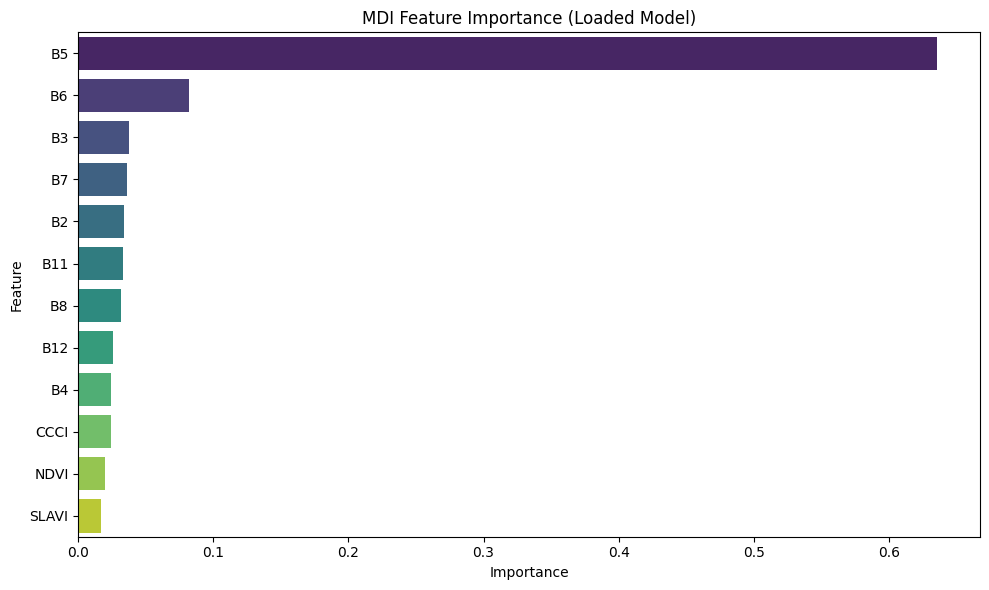

In [ ]:
# MDI - Mean Decrease Impurity from the loaded model
mdi_importances = loaded_rf_model.feature_importances_

# Create DataFrame for plotting
mdi_df = pd.DataFrame({'Feature': FEATURES, 'Importance': mdi_importances})
mdi_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mdi_df, palette='viridis')
plt.title('MDI Feature Importance (Loaded Model)')
plt.tight_layout()
plt.show()

## SHAP (SHapley Additive exPlanations) method
Next, we will use the SHAP method. The SHAP (SHapley Additive exPlanations) method is based on the shapley values, which is a concept from cooperative game theory proposed by Lloyd Shapley (1953). It has been adapted for machine learning model interpretability. In the context of explainable machine learning (xML), shapley values quantify the contribution of each feature to a specific prediction by averaging the marginal contributions it makes when combined with all possible subsets of features. In other words, Shapley Values provide a fair allocation of the "credit" for a prediction among the different features. They offer a holistic understanding of feature importance in machine learning models. To use SHAP in combination with the RandomForestRegressor, we can leverage the shap library in Python.

Let's create an explainer for the RF model. Explainer prints useful information, especially for resolving potential errors.


In [ ]:
# Now you can use SHAP with the loaded model
explainer = shap.Explainer(loaded_rf_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 3620/3626 [02:14<00:00]       

### Create a beeswarm plot
Note that the feature importance only shows the magnitude of the contribution of each predictor variable (band). How, it does not show the direction (negative or positive) of each predictor variable to the model.

Next, let's display them using the beeswarm plot. Keep in mind that Shap explanations are approximations and might not perfectly capture the full complexity of the RF model. However, they can be very useful for gaining insights into understanding feature contributions.

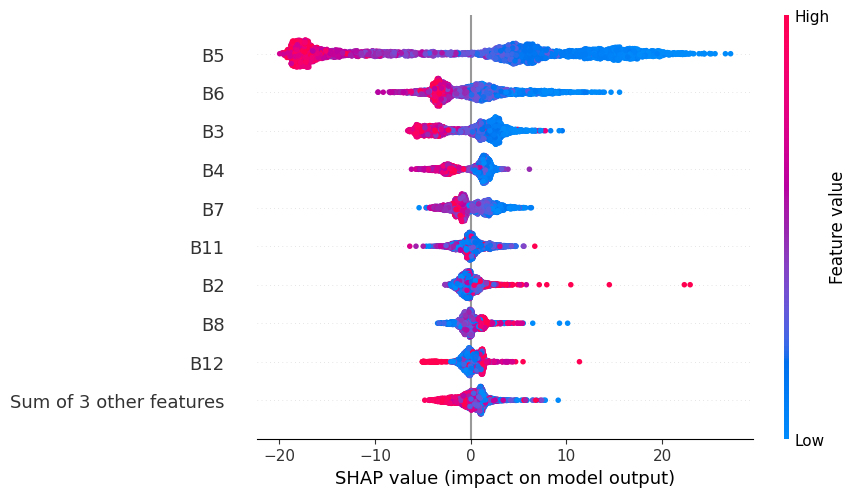

In [ ]:
# Visualize
shap.plots.beeswarm(shap_values)

#### Notes
The SHAP beeswarm plot indicates that Sentinel-2 spectral bands—particularly B5 (red edge), B6, and B3—are the most influential predictors of aboveground biomass density (AGBD) in the random forest model. Notably, B5 shows predominantly negative SHAP values at high feature values (red dots on the left), suggesting a negative relationship with AGBD in this context. Bands such as B11 and B2 demonstrate a moderate influence, with SHAP values distributed more symmetrically around zero, indicating a mixed or neutral effect. Lower-ranked features like B12 and B8 have SHAP values tightly clustered around zero, implying minimal contribution to model predictions. The vegetation indices (NDVI, SLAVI, and CCCI) exhibit less influence overall compared to spectral bands. Among them, NDVI shows a mild positive effect at high values (red dots on the right), which aligns with its known association with vegetation vigor and biomass.

### Create a layered plot
Let's also use a layered plot to gain insights into understanding feature contributions.

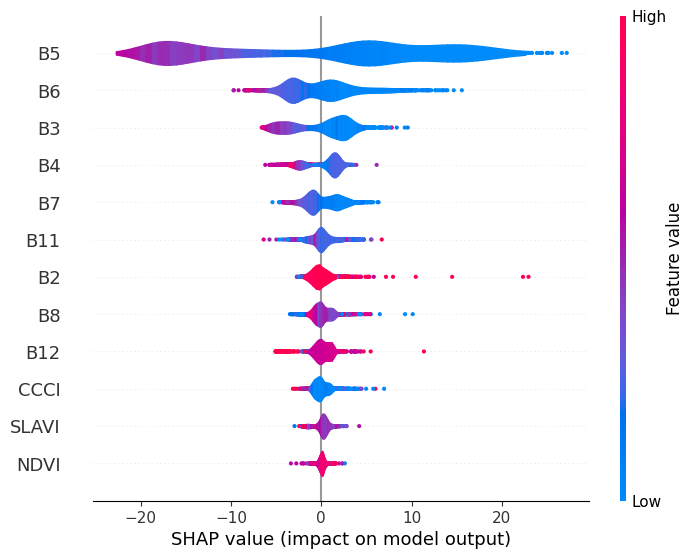

In [ ]:
# Layered violin plot
shap.plots.violin(shap_values, max_display=12)

## Surrogate Decision Tree Model
Next, we wiil use the 'model_surrogate' function to create Global Surrogate models for the RF model. We will use the DecisionTreeRegressor to fit the models. The resulting models can be used to explore and explain the behavior of the original RF model. This can be helpful in understanding complex models and their predictions.

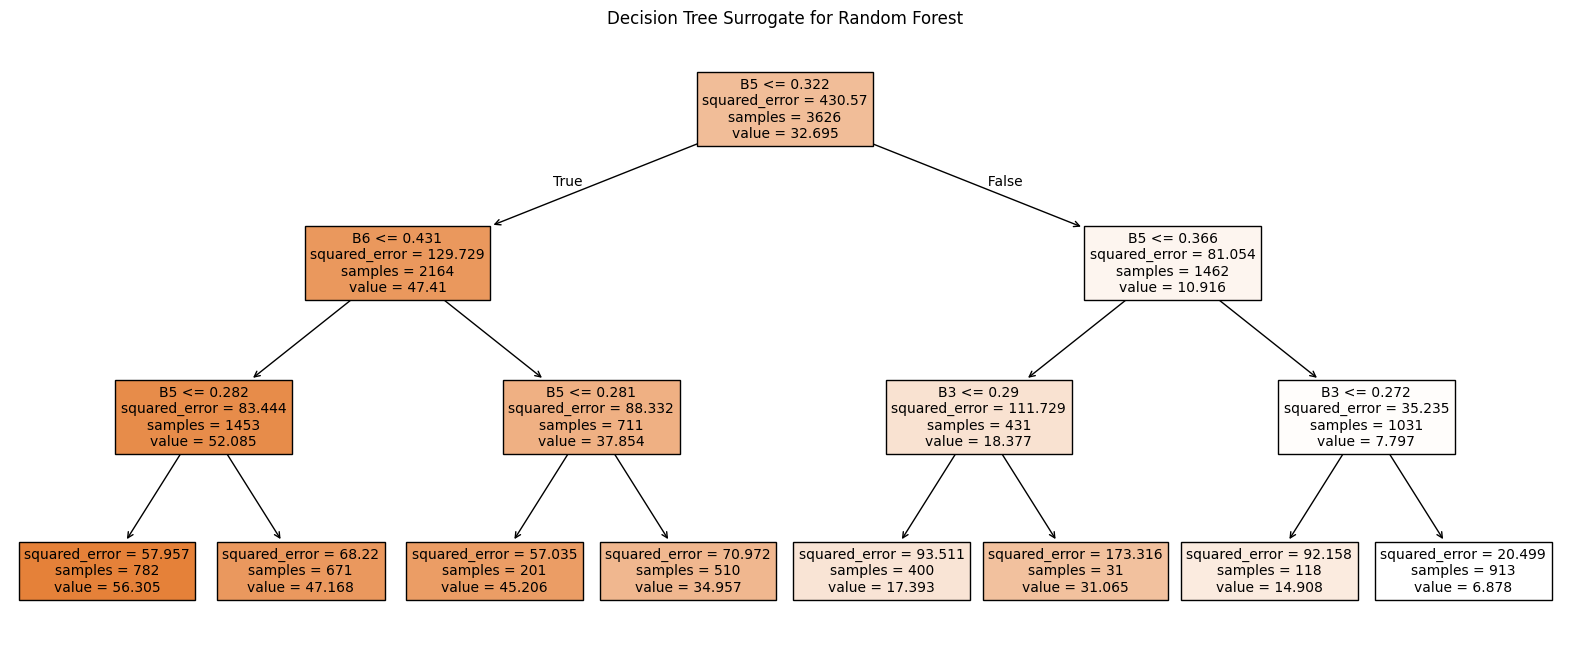

In [ ]:
# Import sklearn decision tree regressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Step 1: Get predictions from the loaded RF model
y_train_pred = loaded_rf_model.predict(X_train)

# Step 2: Train a surrogate Decision Tree
surrogate = DecisionTreeRegressor(max_depth=3, random_state=42)
surrogate.fit(X_train, y_train_pred)

# Step 3: Plot the surrogate decision tree
plt.figure(figsize=(20, 8))
plot_tree(surrogate, feature_names=FEATURES, filled=True, fontsize=10)
plt.title('Decision Tree Surrogate for Random Forest')
plt.show()